In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, add, Activation
from tensorflow.keras import backend as K

In [ ]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs.")
    except RuntimeError as e:
        print(f"Error enabling memory growth: {e}")
else:
    print("No GPU found.")


Memory growth enabled for GPUs.


In [ ]:
#  i have written a seperate code for resizing the image

In [ ]:
H = 256
W = 256
batch_size = 8
lr = 1e-3 #0.0001

### Data Loading

In [ ]:
def load_data(data_path, split=0.2):
    masks = sorted(glob(data_path + '/*mask.png'))
    images = sorted(glob(data_path + '/*sat.jpg'))
    size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=0.1, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=0.1, random_state=42)

    return (train_x, train_y), (valid_x, valid_y)

In [ ]:
def read_image(path):
    try:
        img = Image.open(path)
        x = np.array(img, dtype=np.float32)
        x = x / 255.0
        return x
    except Exception as e:
        print(f"Error while reading image: {e}")
        return None
def read_mask(path):
    try:
        img = Image.open(path).convert('L')
        x = np.array(img, dtype=np.float32)
        x = x / 255.0
        x = np.expand_dims(x, axis=-1)
        return x
    except Exception as e:
        print(f"Error while reading mask: {e}")
        return None

In [ ]:
def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

def tf_parse(x, y):
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y


def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)

    return dataset

In [ ]:
data_path = "./train"
(train_x, train_y), (valid_x, valid_y) = load_data(data_path)

In [ ]:
len(train_x), len(train_y), len(valid_x), len(valid_y)

(5603, 5603, 623, 623)

In [ ]:
import random

In [ ]:
def show_random_sample(image_dataset = train_x, mask_datset = train_y, mask = True):

    rand_index =random.randint(0, len(image_dataset) - 1)
    plt.figure(figsize=(7, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(read_image(image_dataset[rand_index]))
    plt.title('Image')

    if mask:
        plt.subplot(1, 2, 2)
        plt.imshow(read_mask(mask_datset[rand_index]), cmap = "gray")
        plt.title('Mask')

    plt.show()

In [ ]:
def predict(model,path, save_path = None):
    img=cv2.imread(path)
    # print(img)
    img = cv2.resize(img, (H, W))
    # cv2.imwrite(path, img)
    # # original image
    # img = plt.imread(path)
    inp_img  = np.expand_dims(img, axis=0)

    # prediction
    pred = model.predict(inp_img/255.0)
    pred = pred.reshape(256,256)
    print(pred.shape)
    threshold = threshold_otsu(pred)
    print(threshold)
    th, pred = cv2.threshold(pred, threshold, 1 , cv2.THRESH_BINARY)
    print(pred.shape)
    # print(pred)
    image_title = path.split('/')[-1]

    plt.figure(figsize=(10, 6))

    plt.subplot(1,2,1)
    plt.title(image_title)
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.title(f"Prediction - {image_title}")
    plt.imshow(pred, cmap='gray')
    if save_path:
        plt.imsave(save_path, pred, cmap='gray')

    plt.show()

In [ ]:
def pred_dataset(model, dataset, num = 5):
    # num is no. of images to be predicted
    # dataset is a list containg img path
    for i in range(min(num, len(dataset))):
        pedict(model, dataset[i])

In [ ]:
def plot_accuracy_loss(history):
    x = list(range(len(history.history['accuracy'])))

    plt.figure(figsize = (10,4))
    plt.subplot(1,2,1)
    plt.plot(x, history.history['accuracy'], label = "train_accuracy")
    plt.plot(x, history.history['val_accuracy'], label = "val_accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x, history.history['loss'], label = "loss")
    plt.plot(x, history.history['val_loss'], label = "val_loss")
    plt.legend()
    plt.show()

In [ ]:
def get_dataset_score(dataset, model):
    iou_scores = []
    dice_scores = []
    for batch in dataset:
        images, masks = batch
        # print(images.shape)
        preds = model.predict(images)
        for i in range(len(images)):
            y_true = masks[i]
            y_pred = preds[i]

            score_iou = iou_score(y_true, y_pred)
            score_dice = dice_score(y_true, y_pred)
            print(score_iou)
            # break
            iou_scores.append(score_iou)
            dice_scores.append(score_dice)
        # break
    return iou_scores, dice_scores

In [ ]:
def visualize_predictions(model, dataset, num_images=1):
    for images, masks in dataset.take(num_images):
        preds = model.predict(images)
        for i in range(len(images)):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Input Image")


            plt.subplot(1, 3, 2)
            plt.imshow(np.array(masks[i]).squeeze(), cmap='gray')
            plt.title("True Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(np.array(preds[i]).squeeze(), cmap='gray')
            plt.title("Predicted Mask")

            plt.show()

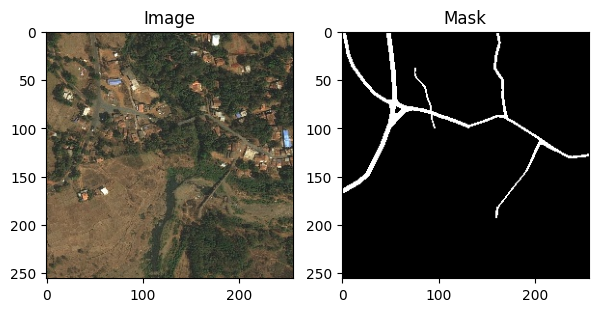

In [ ]:
show_random_sample()

In [ ]:
# iou and dice score

In [ ]:
def iou_score(y_true, y_pred):
    y_true = np.array(y_true).reshape(H,W)
    y_pred = np.array(y_pred)
    pmask_thresh = threshold_otsu(y_pred)
    th, y_pred = cv2.threshold(y_pred, pmask_thresh, 1, cv2.THRESH_BINARY)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + 1e-15) / (union + 1e-15)

def dice_score(y_true, y_pred):
    smooth = 1e-15
    y_true = np.array(y_true).reshape(H,W)
    y_pred = np.array(y_pred)
    pmask_thresh = threshold_otsu(y_pred)
    th, y_pred = cv2.threshold(y_pred, pmask_thresh, 1, cv2.THRESH_BINARY)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=8)
valid_dataset = tf_dataset(valid_x, valid_y, batch=8)
train_steps = (len(train_x) // 8)
valid_steps = (len(valid_x) // 8)

In [ ]:
def conv_block(x, size, dropout, batch_norm=False, filter_size = 3 , res_unet = False):

    conv = Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm:
        conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)

    conv = Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm :
        conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)

    if dropout > 0:
        conv = Dropout(dropout)(conv)

    if res_unet :
        shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
        if batch_norm is True:
            shortcut = BatchNormalization()(shortcut)

        res_path = add([shortcut, conv])
        conv = Activation('relu')(res_path)

    return conv

In [ ]:
def UNet(input_shape, dropout_rate=0.05, batch_norm=True, res_unet = False):

    # network structure
    FILTER_NUM = 16
    FILTER_SIZE = 3
    UP_SAMP_SIZE = 2


    inputs = Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    conv_128 = conv_block(inputs, FILTER_NUM, dropout_rate, batch_norm, res_unet = res_unet)
    pool_64 = MaxPooling2D(pool_size=(2,2))(conv_128)
    conv_64 = conv_block(pool_64, 2*FILTER_NUM, dropout_rate, batch_norm, res_unet = res_unet)
    pool_32 = MaxPooling2D(pool_size=(2,2))(conv_64)
    conv_32 = conv_block(pool_32, 4*FILTER_NUM, dropout_rate, batch_norm, res_unet = res_unet)
    pool_16 = MaxPooling2D(pool_size=(2,2))(conv_32)
    conv_16 = conv_block(pool_16, 8*FILTER_NUM, dropout_rate, batch_norm, res_unet = res_unet)
    pool_8 = MaxPooling2D(pool_size=(2,2))(conv_16)

    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, 16*FILTER_NUM, dropout_rate, batch_norm, res_unet = res_unet)

    # Upsampling layers
    up_16 = Conv2DTranspose(filters=8*FILTER_NUM, kernel_size=(3, 3), strides=(2, 2), padding='same')(conv_8)
    up_16 = concatenate([up_16, conv_16])
    up_conv_16 = conv_block(up_16, 8*FILTER_NUM, dropout_rate, batch_norm, res_unet = res_unet)
    # UpRes 7

    up_32 = Conv2DTranspose(filters=4*FILTER_NUM, kernel_size=(3, 3), strides=(2, 2), padding='same')(up_conv_16)
    up_32 = concatenate([up_32, conv_32])
    up_conv_32 = conv_block(up_32, 4*FILTER_NUM, dropout_rate, batch_norm, res_unet = res_unet)
    # UpRes 8
    , res_unet = res_unet
    up_64 = Conv2DTranspose(filters=2*FILTER_NUM, kernel_size=(3, 3), strides=(2, 2), padding='same')(up_conv_32)
    up_64 = concatenate([up_64, conv_64])
    up_conv_64 = conv_block(up_64, 2*FILTER_NUM, dropout_rate, batch_norm, res_unet = res_unet)
    # UpRes 9

    up_128 = Conv2DTranspose(filters=FILTER_NUM, kernel_size=(3, 3), strides=(2, 2), padding='same')(up_conv_64)
    up_128 = concatenate([up_128, conv_128])
    up_conv_128 = conv_block(up_128, FILTER_NUM, dropout_rate, batch_norm, res_unet = res_unet)

    # 1*1 convolutional layers

    conv_final = Conv2D(1, kernel_size=(1,1))(up_conv_128)
    conv_final = BatchNormalization()(conv_final)
    conv_final = Activation('sigmoid')(conv_final)

    # Model
    model = Model(inputs, conv_final, name="UNet")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
simple_unet = UNet((256,256,3))

In [ ]:
dot_img_file = './model_1.png'
# tf.keras.utils.plot_model(simple_unet, to_file=dot_img_file, show_shapes=True)

In [ ]:
model_path = './model/unet.h5'
model_save_callback = tf.keras.callbacks.ModelCheckpoint( filepath=model_path, save_weights_only=True, save_best_only=True)
callbacks = [model_save_callback]

In [ ]:
history_unet = simple_unet.fit(train_dataset, epochs=25, validation_data=valid_dataset, callbacks=callbacks, shuffle = True)

Epoch 1/25
701/701 [==============================] - 131s 187ms/step - loss: 0.5311 - accuracy: 0.9078 - val_loss: 0.4060 - val_accuracy: 0.9592
Epoch 2/25
701/701 [==============================] - 130s 185ms/step - loss: 0.3408 - accuracy: 0.9586 - val_loss: 0.2704 - val_accuracy: 0.9613
Epoch 3/25
701/701 [==============================] - 130s 185ms/step - loss: 0.2402 - accuracy: 0.9645 - val_loss: 0.2054 - val_accuracy: 0.9616
Epoch 4/25
701/701 [==============================] - 130s 185ms/step - loss: 0.1828 - accuracy: 0.9670 - val_loss: 0.1709 - val_accuracy: 0.9612
Epoch 5/25
701/701 [==============================] - 6340s 9s/step - loss: 0.1478 - accuracy: 0.9684 - val_loss: 0.1407 - val_accuracy: 0.9641
Epoch 6/25
701/701 [==============================] - 120s 171ms/step - loss: 0.1251 - accuracy: 0.9693 - val_loss: 0.1332 - val_accuracy: 0.9630
Epoch 7/25
701/701 [==============================] - 107s 153ms/step - loss: 0.1097 - accuracy: 0.9701 - val_loss: 0.1154 - v

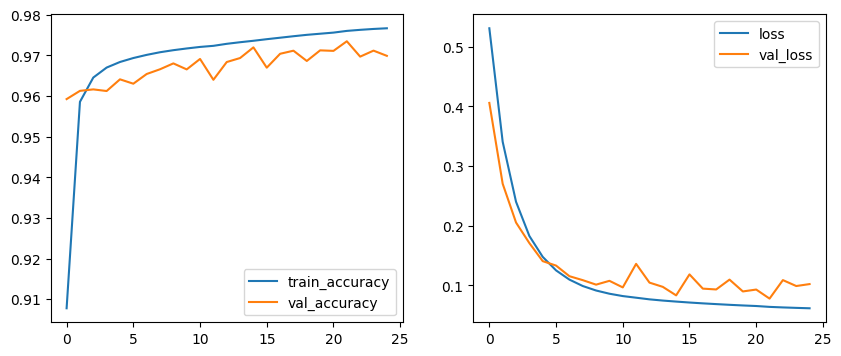

In [ ]:
plot_accuracy_loss(history_unet)

In [ ]:
simple_unet.load_weights("./model/unet.h5")

In [ ]:
iou, dice = get_dataset_score(valid_dataset, simple_unet)

1/1 [==============================] - 0s 22ms/step
0.6326705152875776
0.6053307642903019
0.5
0.46144355336212217
0.5478299876640126
0.4747191011235955
0.6903169526025007
0.6036341238065907
1/1 [==============================] - 0s 21ms/step
0.6243351063829787
0.6791208791208792
0.25538911216660576
0.23577235772357724
0.5535934291581108
0.7230769230769231
0.3148109021762096
0.5676818950930627
1/1 [==============================] - 0s 28ms/step
0.41946768060836503
0.47376664056382145
0.5102880658436214
0.6883802816901409
0.33346243222308286
0.2688821752265861
0.8694214876033057
0.41746395364506134
1/1 [==============================] - 0s 23ms/step
0.4533116178067318
0.422992700729927
0.5
0.3960431654676259
0.4665127020785219
0.6198630136986302
0.4663726571113561
0.2370848708487085
1/1 [==============================] - 0s 31ms/step
0.1336794289422453
0.4809575625680087
0.6232179226069247
0.20748299319727892
0.434341252699784
0.3406130268199234
0.39484583525080535
0.30198446937014667
1/

In [ ]:
np.mean(iou), np.mean(dice)

(0.48018591680870437, 0.6317379559963076)

In [ ]:
history_unet2 = simple_unet.fit(train_dataset, epochs=1, validation_data=valid_dataset, callbacks=callbacks, shuffle = True)

701/701 [==============================] - 110s 157ms/step - loss: 0.0527 - accuracy: 0.9796 - val_loss: 0.0787 - val_accuracy: 0.9739


1/1 [==============================] - 0s 32ms/step
(256, 256)
0.31491923
(256, 256)


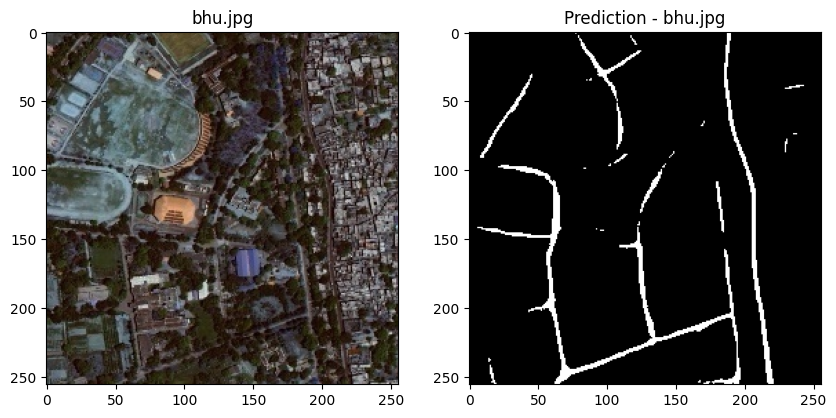

In [ ]:
predict(simple_unet, "./bhu.jpg", "./simple_unet_bhu.jpg")

1/1 [==============================] - 0s 21ms/step
(256, 256)
0.33437353
(256, 256)


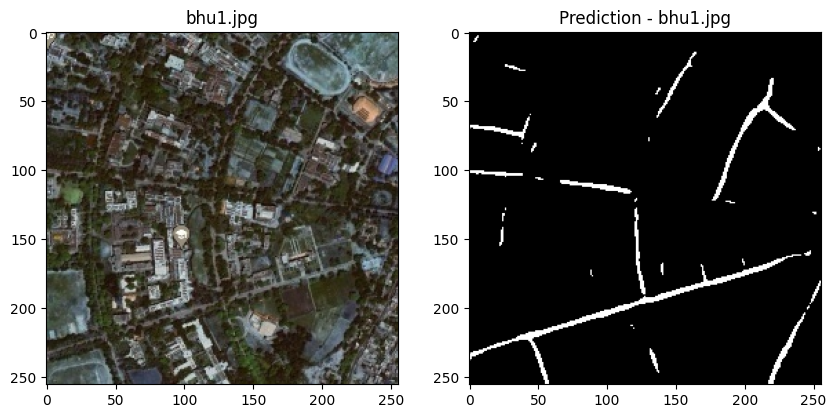

In [ ]:
predict(simple_unet, "./bhu1.jpg", "./simple_unet_bhu1.jpg")

1/1 [==============================] - 0s 23ms/step
(256, 256)
0.35387397
(256, 256)


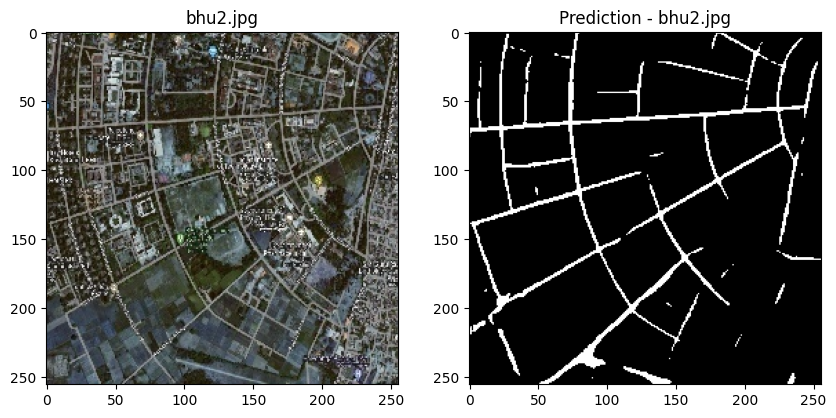

In [ ]:
predict(simple_unet, "./bhu2.jpg", "./simple_unet_bhu2.jpg")

1/1 [==============================] - 0s 31ms/step


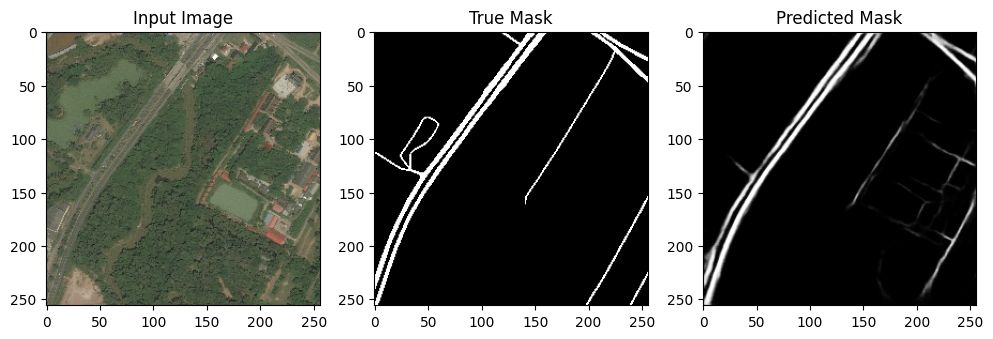

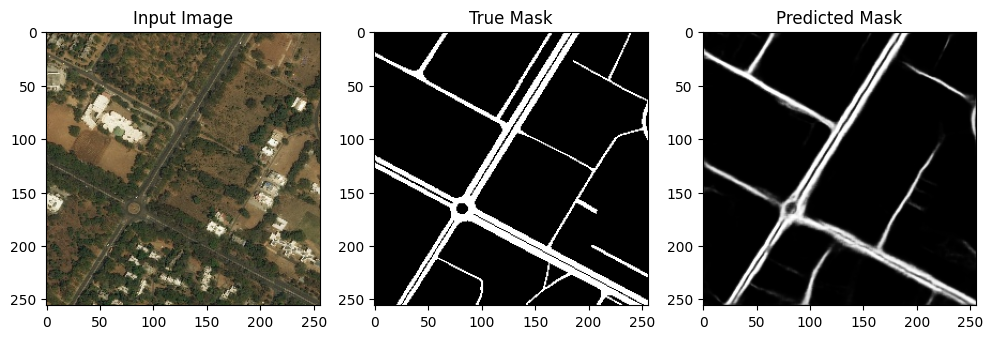

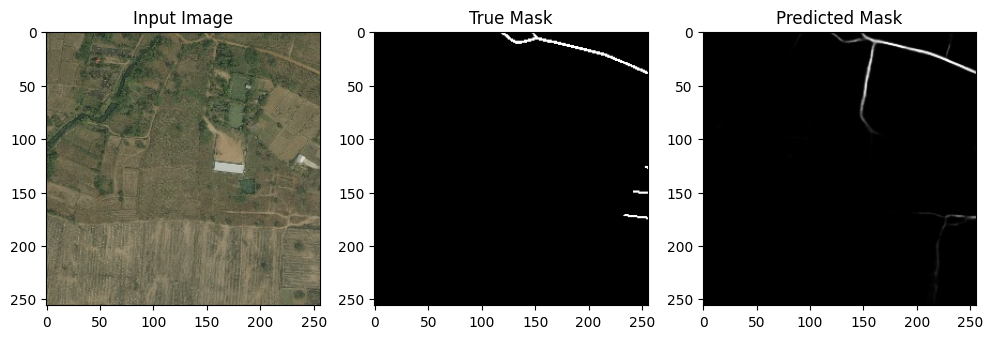

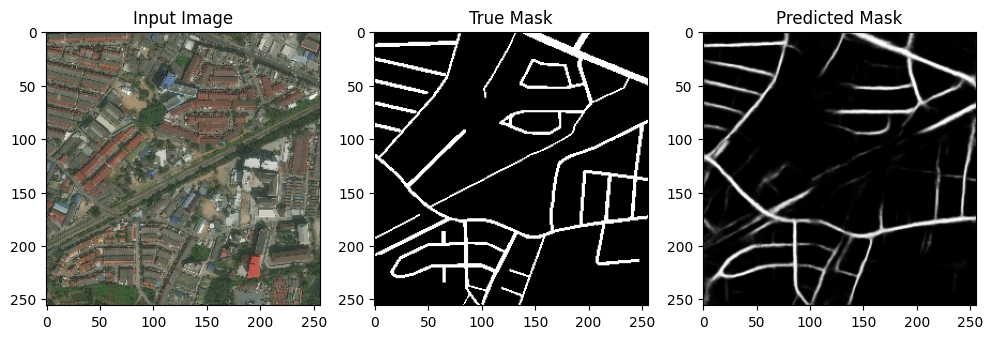

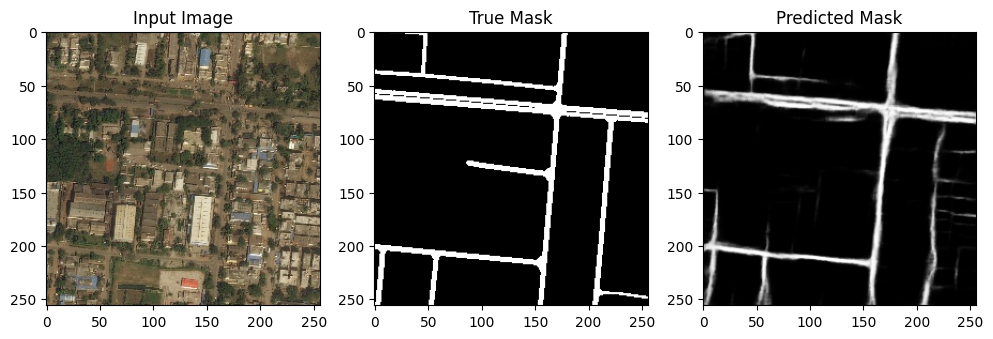

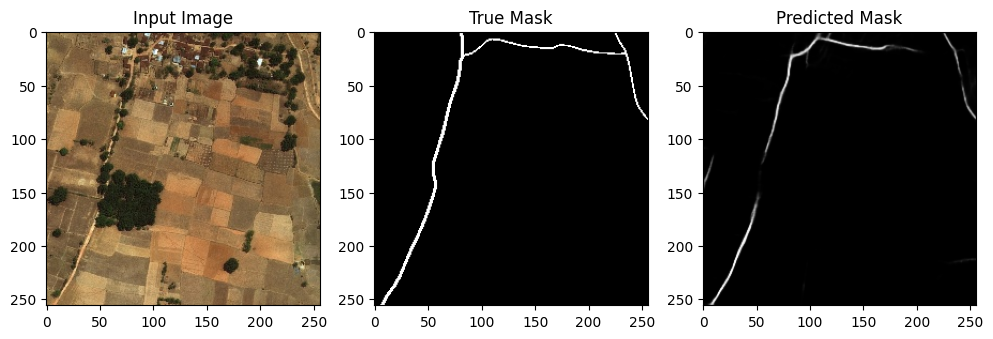

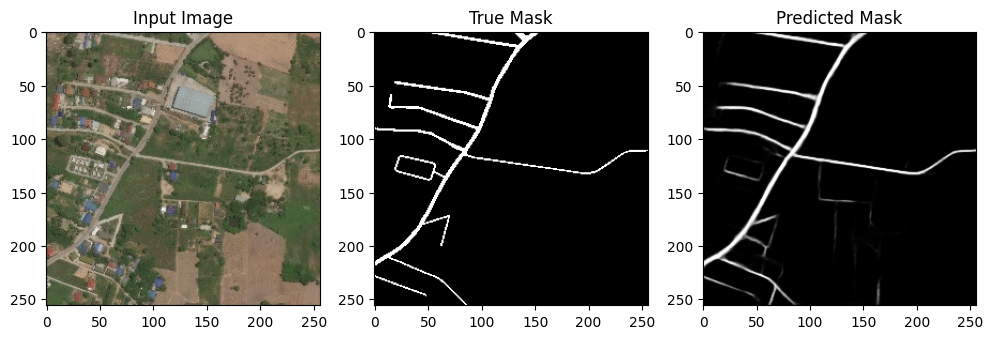

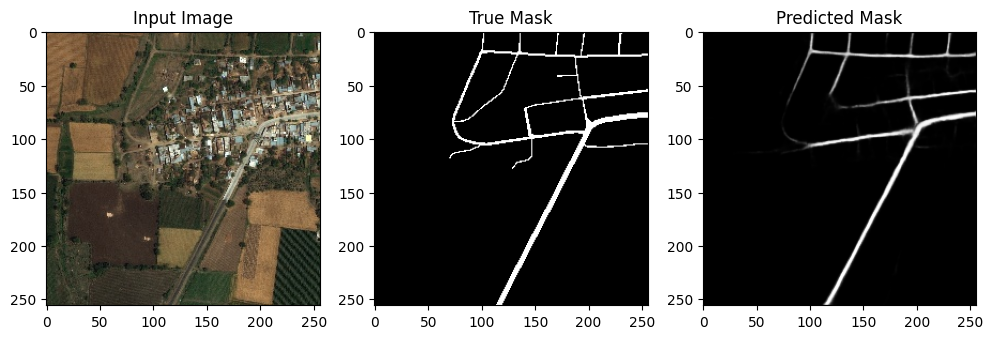

In [ ]:
# Visualize predictions
visualize_predictions(simple_unet, valid_dataset, num_images=1)

In [ ]:
res_unet = UNet((256,256,3), res_unet = True)

In [ ]:
dot_img_file = './res_unet.png'
# tf.keras.utils.plot_model(res_unet, to_file=dot_img_file, show_shapes=True)

In [ ]:
res_model_path = './model/res_unet.h5'
res_model_save_callback = tf.keras.callbacks.ModelCheckpoint( filepath=res_model_path, save_weights_only=True, save_best_only=True)
res_callbacks = [res_model_save_callback]

In [ ]:
res_history_unet = res_unet.fit(train_dataset, epochs=15, validation_data=valid_dataset, callbacks=res_callbacks, shuffle = True)

Epoch 1/15
701/701 [==============================] - 131s 187ms/step - loss: 0.5375 - accuracy: 0.8898 - val_loss: 0.5658 - val_accuracy: 0.9523
Epoch 2/15
701/701 [==============================] - 137s 196ms/step - loss: 0.3420 - accuracy: 0.9583 - val_loss: 0.2654 - val_accuracy: 0.9638
Epoch 3/15
701/701 [==============================] - 143s 204ms/step - loss: 0.2373 - accuracy: 0.9662 - val_loss: 0.1943 - val_accuracy: 0.9684
Epoch 4/15
701/701 [==============================] - 147s 209ms/step - loss: 0.1785 - accuracy: 0.9689 - val_loss: 0.1525 - val_accuracy: 0.9689
Epoch 5/15
701/701 [==============================] - 150s 214ms/step - loss: 0.1427 - accuracy: 0.9705 - val_loss: 0.1277 - val_accuracy: 0.9700
Epoch 6/15
701/701 [==============================] - 145s 207ms/step - loss: 0.1192 - accuracy: 0.9717 - val_loss: 0.1112 - val_accuracy: 0.9706
Epoch 7/15
701/701 [==============================] - 146s 209ms/step - loss: 0.1035 - accuracy: 0.9726 - val_loss: 0.1002 -

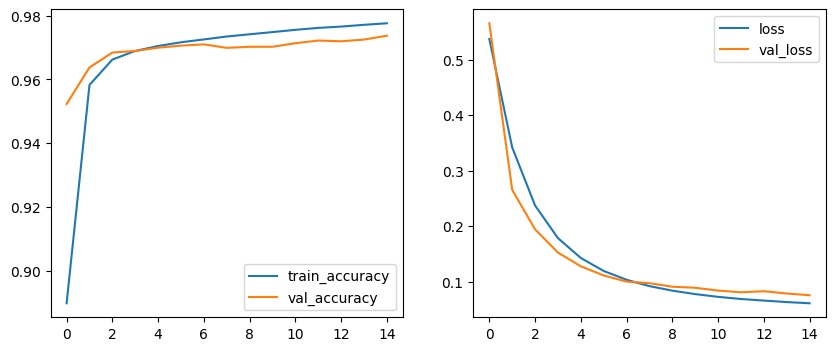

In [ ]:
plot_accuracy_loss(res_history_unet)

In [ ]:
iou, dice = get_dataset_score(valid_dataset, res_unet)

1/1 [==============================] - 1s 578ms/step
0.5776561232765612
0.5825857519788918
0.39285714285714285
0.512340343801018
0.5417843321828261
0.5732130464954892
0.6972732331663885
0.6173424089967446
1/1 [==============================] - 0s 26ms/step
0.586914688903143
0.6644951140065146
0.4465366509751177
0.2925365344467641
0.5728211843445365
0.7902494331065759
0.27296878459154306
0.522326915198689
1/1 [==============================] - 0s 22ms/step
0.40421917032422483
0.49428789032749426
0.3433155080213904
0.6900175131348512
0.3938867662382772
0.22140522875816993
0.8662262592898431
0.36511211996148024
1/1 [==============================] - 0s 16ms/step
0.49734427812650894
0.46222664015904574
0.5030042918454936
0.3746606334841629
0.3383106752841542
0.6014362657091562
0.43824485373781147
0.23076923076923078
1/1 [==============================] - 0s 25ms/step
0.1532404603270745
0.731404958677686
0.3401273885350318
0.26861702127659576
0.4751513885988724
0.37362637362637363
0.4730713

In [ ]:
np.mean(iou), np.mean(dice)

(0.48613435828922635, 0.6364291503140005)

1/1 [==============================] - 0s 29ms/step
(256, 256)
0.28552
(256, 256)


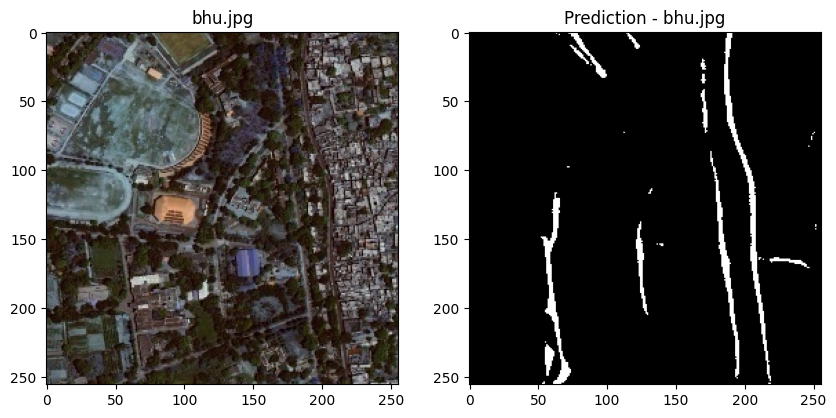

In [ ]:
predict(res_unet, "./bhu.jpg", "./res_unet_bhu.jpg")

1/1 [==============================] - 0s 34ms/step
(256, 256)
0.30716258
(256, 256)


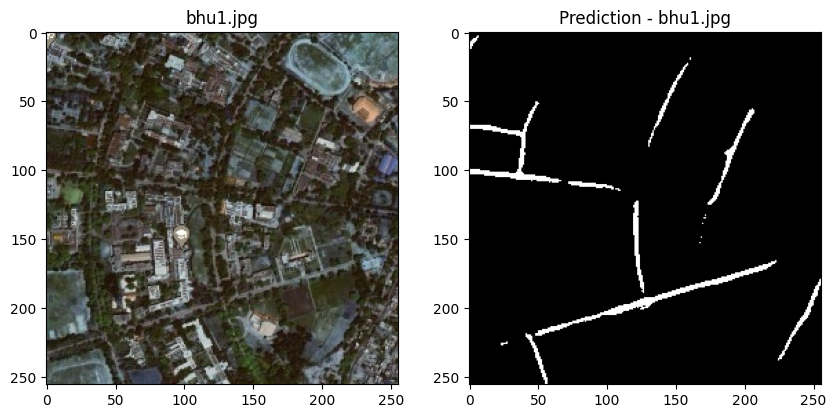

In [ ]:
predict(res_unet, "./bhu1.jpg", "./res_unet_bhu1.jpg")

1/1 [==============================] - 0s 32ms/step
(256, 256)
0.32275847
(256, 256)


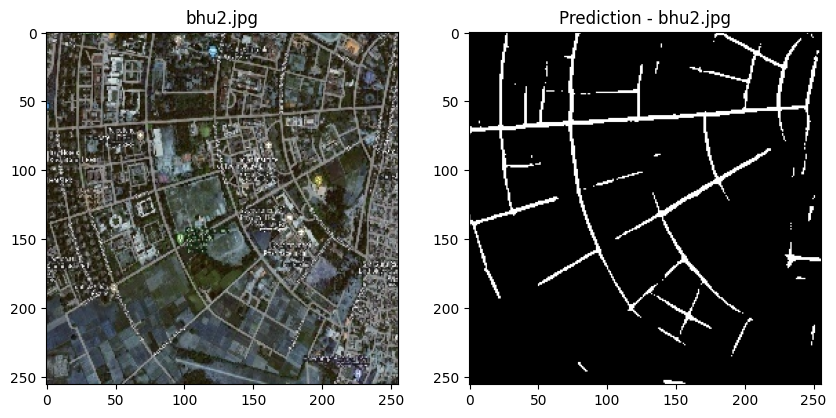

In [ ]:
predict(res_unet, "./bhu2.jpg", "./res_unet_bhu2.jpg")

1/1 [==============================] - 0s 26ms/step


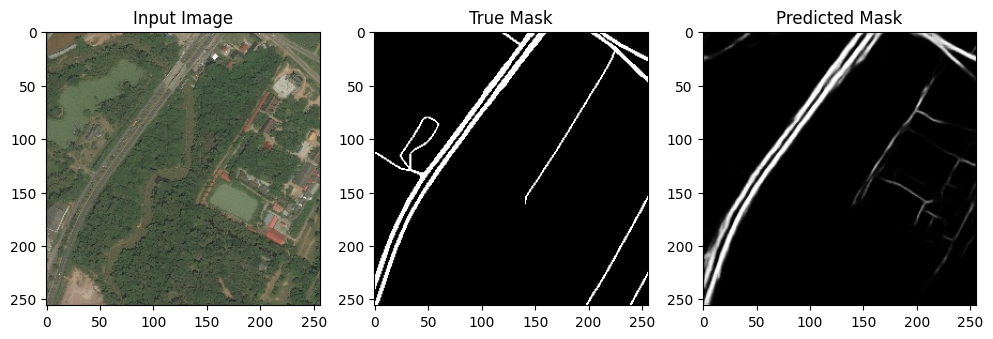

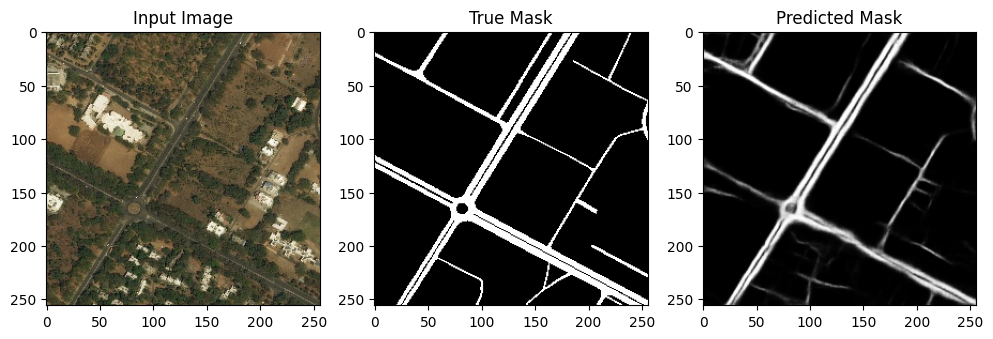

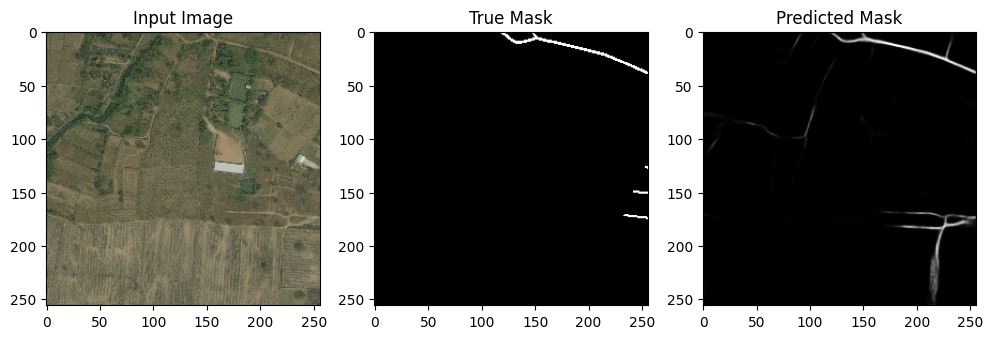

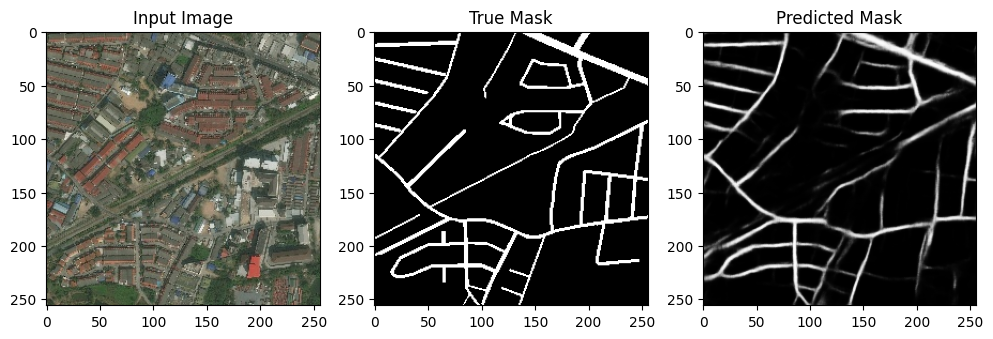

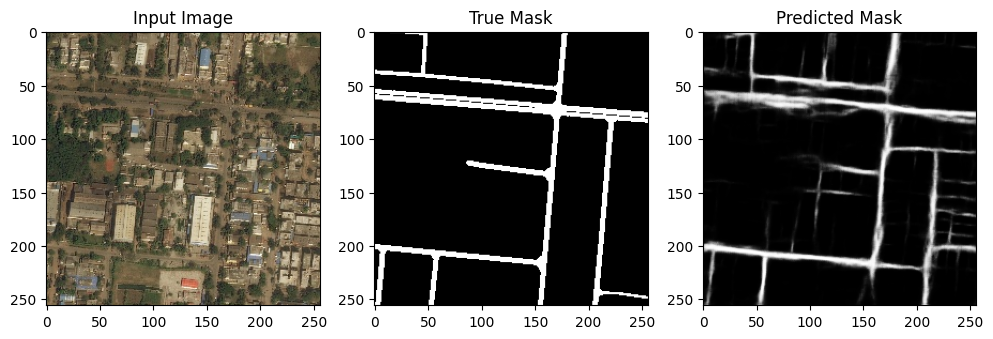

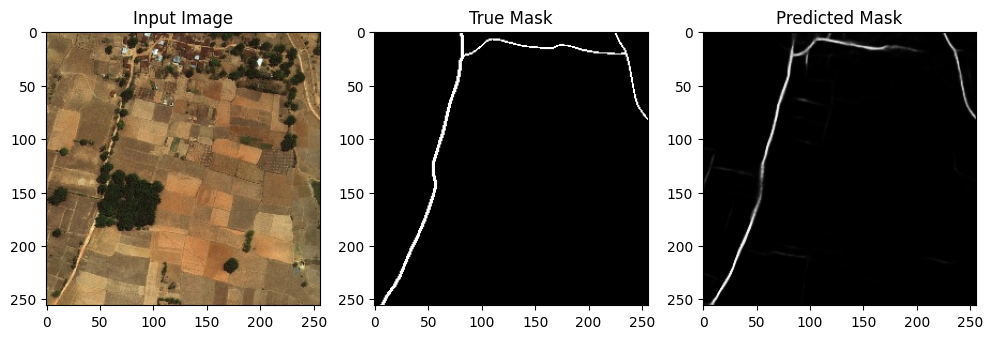

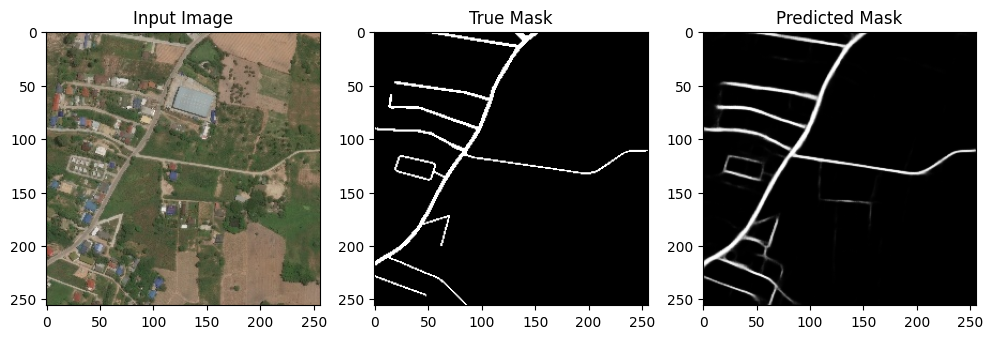

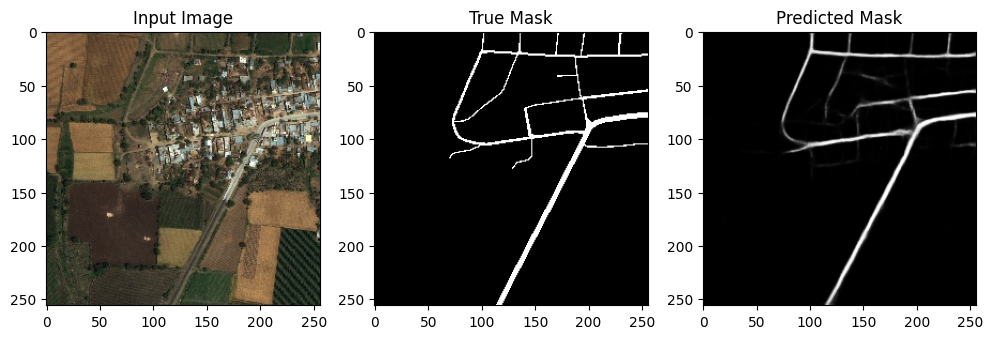

In [ ]:
visualize_predictions(res_unet, valid_dataset, num_images=1)

In [ ]:
# Applying Backbone

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
def ResNet50_UNet(input_shape, dropout_rate=0.1, batch_norm=True, res_unet = False):

    # network structure
    FILTER_NUM = 16
    FILTER_SIZE = 3
    UP_SAMP_SIZE = 2


    inputs = Input(input_shape, dtype=tf.float32)
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in resnet50.layers:
        layer.trainable = False
        if layer.name == 'conv2_block3_out':
            break


    conv_128 = resnet50.get_layer("conv1_relu").output
    conv_64 = resnet50.get_layer("conv2_block3_out").output
    conv_32 = resnet50.get_layer("conv3_block4_out").output
    conv_16 = resnet50.get_layer("conv4_block6_out").output

    # DownRes 5, convolution only
    conv_8 = resnet50.get_layer("conv5_block3_out").output

    # Upsampling layers
    up_16 = Conv2DTranspose(filters=8*FILTER_NUM, kernel_size=(3, 3), strides=(2, 2), padding='same')(conv_8)
    up_16 = concatenate([up_16, conv_16])
    up_conv_16 = conv_block(up_16, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7

    up_32 = Conv2DTranspose(filters=4*FILTER_NUM, kernel_size=(3, 3), strides=(2, 2), padding='same')(up_conv_16)
    up_32 = concatenate([up_32, conv_32])
    up_conv_32 = conv_block(up_32, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    , res_unet = res_unet
    up_64 = Conv2DTranspose(filters=2*FILTER_NUM, kernel_size=(3, 3), strides=(2, 2), padding='same')(up_conv_32)
    up_64 = concatenate([up_64, conv_64])
    up_conv_64 = conv_block(up_64, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9

    up_128 = Conv2DTranspose(filters=FILTER_NUM, kernel_size=(3, 3), strides=(2, 2), padding='same')(up_conv_64)
    up_128 = concatenate([up_128, conv_128])
    up_conv_128 = conv_block(up_128, FILTER_NUM, dropout_rate, batch_norm)

    up_128 = Conv2DTranspose(filters=FILTER_NUM, kernel_size=(3, 3), strides=(2, 2), padding='same')(up_conv_128)

    # 1*1 convolutional layers

    conv_final = Conv2D(1, kernel_size=(1,1))(up_128)
    conv_final = BatchNormalization()(conv_final)
    conv_final = Activation('sigmoid')(conv_final)

    # Model
    model = Model(inputs, conv_final, name="Resnet50")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
resnet50_unet = ResNet50_UNet((256,256,3))

In [ ]:
dot_img_file = './resnet50_unet.png'
resnet50_unet.summary()
# tf.keras.utils.plot_model(resnet50_unet, to_file=dot_img_file, show_shapes=True)

Model: "Resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_20[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
resnet50_model_path = './model/resnet50_unet.h5'
resnet50_model_save_callback = tf.keras.callbacks.ModelCheckpoint( filepath=resnet50_model_path, save_weights_only=True, save_best_only=True)
resnet50_callbacks = [resnet50_model_save_callback]

In [ ]:
resnet50_unet.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
resnet50_history = resnet50_unet.fit(train_dataset, epochs=10, validation_data=valid_dataset, callbacks=resnet50_callbacks, shuffle = True)

Epoch 1/10
701/701 [==============================] - 159s 220ms/step - loss: 0.1270 - accuracy: 0.9593 - val_loss: 0.1658 - val_accuracy: 0.9570
Epoch 2/10
701/701 [==============================] - 143s 204ms/step - loss: 0.1102 - accuracy: 0.9614 - val_loss: 0.1955 - val_accuracy: 0.9570
Epoch 3/10
701/701 [==============================] - 140s 200ms/step - loss: 0.1042 - accuracy: 0.9627 - val_loss: 0.3174 - val_accuracy: 0.9570
Epoch 4/10
701/701 [==============================] - 144s 205ms/step - loss: 0.0996 - accuracy: 0.9639 - val_loss: 0.2640 - val_accuracy: 0.9571
Epoch 5/10
701/701 [==============================] - 146s 209ms/step - loss: 0.0958 - accuracy: 0.9650 - val_loss: 0.6290 - val_accuracy: 0.9569
Epoch 6/10
142/701 [=====>........................] - ETA: 2:15 - loss: 0.0927 - accuracy: 0.9657

In [ ]:
resnet50_unet.load_weights(resnet50_model_path)

In [ ]:
plot_accuracy_loss(resnet50_history)

NameError: name 'resnet50_history' is not defined

In [ ]:
iou, dice = get_dataset_score(valid_dataset, resnet50_unet)

In [ ]:
np.mean(iou), np.mean(dice)

1/1 [==============================] - 0s 37ms/step
(256, 256)
0.06844397
(256, 256)


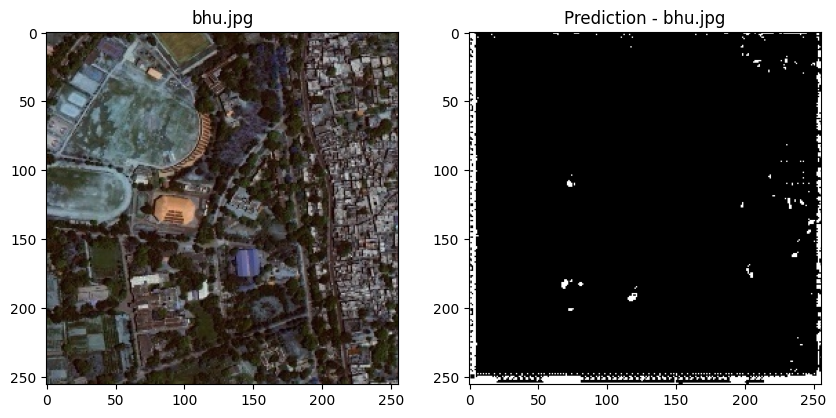

In [ ]:
predict(resnet50_unet, "./bhu.jpg", "./res_unet_bhu.jpg")

1/1 [==============================] - 0s 22ms/step
(256, 256)
0.07926756
(256, 256)


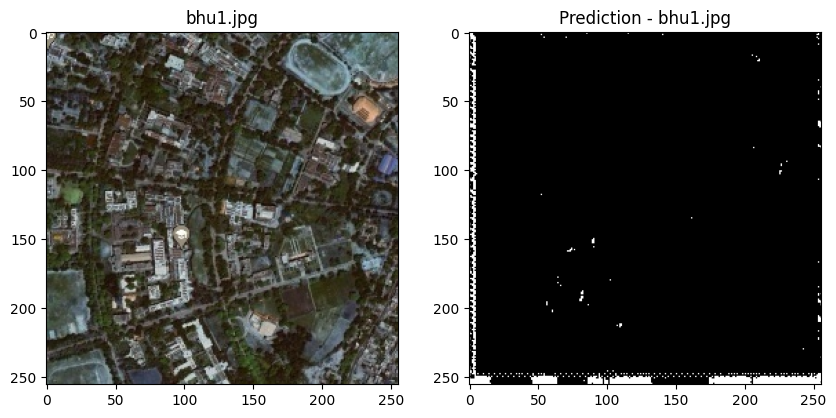

In [ ]:
predict(resnet50_unet, "./bhu1.jpg", "./res_unet_bhu1.jpg")

1/1 [==============================] - 0s 22ms/step
(256, 256)
0.10537355
(256, 256)


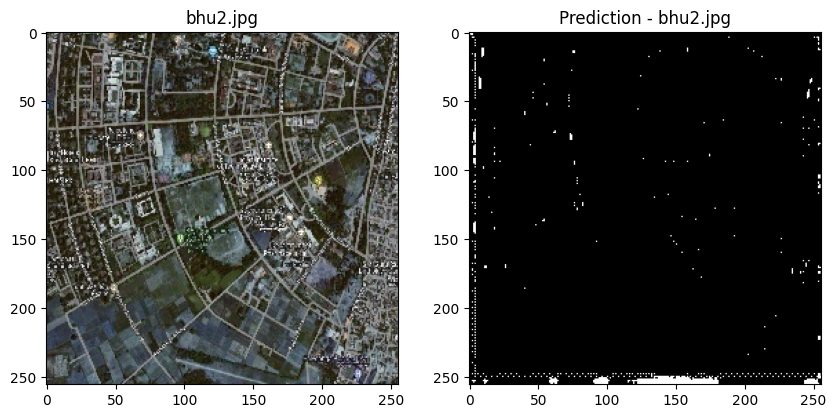

In [ ]:
predict(resnet50_unet, "./bhu2.jpg", "./res_unet_bhu2.jpg")

In [ ]:
visualize_predictions(resnet50_unet, valid_dataset, num_images=1)